In [1]:
# ============================================================
# Notebook setup: run this before everything
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 4)

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from util import util
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

# Load data
data_folder = '/app/data/nab'
file_name = 'realKnownCause/nyc_taxi.csv'
data, labels, windows = util.load_series(file_name, data_folder)

# Train and validation end
train_end = pd.to_datetime('2014-10-24 00:00:00')
val_end = pd.to_datetime('2014-12-10 00:00:00')

# Cost model parameters
c_alrm = 1 # Cost of investigating a false alarm
c_missed = 10 # Cost of missing an anomaly
c_late = 5 # Cost for late detection

# Separate the training data
data_tr = data[data.index < train_end]

# Build a cost model
cmodel = util.ADSimpleCostModel(c_alrm, c_missed, c_late)

# Sliding Windows

## Temporal Correlations

**Let's have a closer look at our time series**

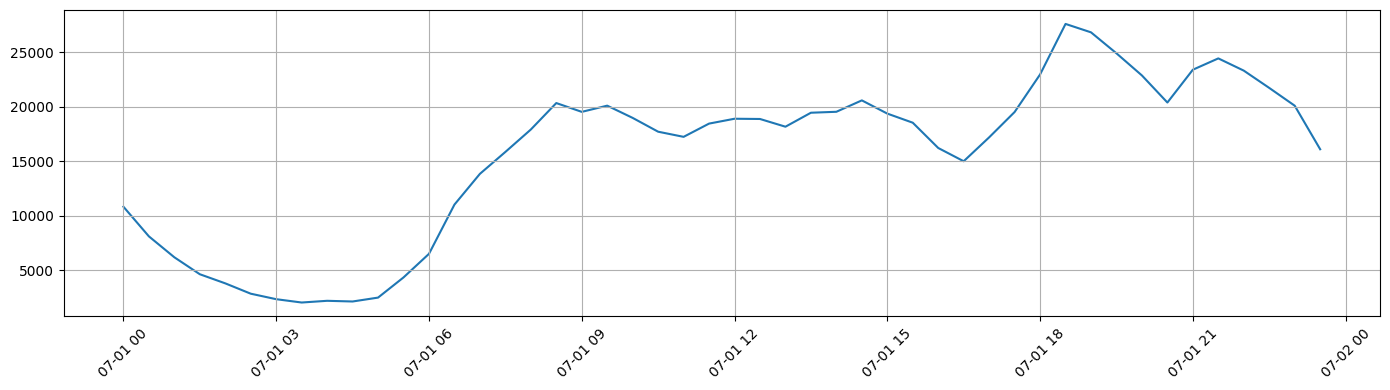

In [2]:
util.plot_series(data.iloc[:48], figsize=figsize)

* Nearby points tend to have similar values
* ...Meaning they are _correlated_

## Determine the Correlation Interval

**How can we study such correlation?**

A useful tool: [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation) plots

* Consider a range of possible _lags_
* For each lag value $l$:
  - Make a copy of the series and shift it by $l$ time steps
  - Compute the [Pearson Correlation Coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) with the original series
* Plot the correlation coefficients over the lag values

**Then we look at the resulting plot:**

* Where the curve is far from zero, there is a significant correlation
* Where it gets close to zero, no significant correlation exists

## Temporal Correlations

**Let's have a look at our plot**

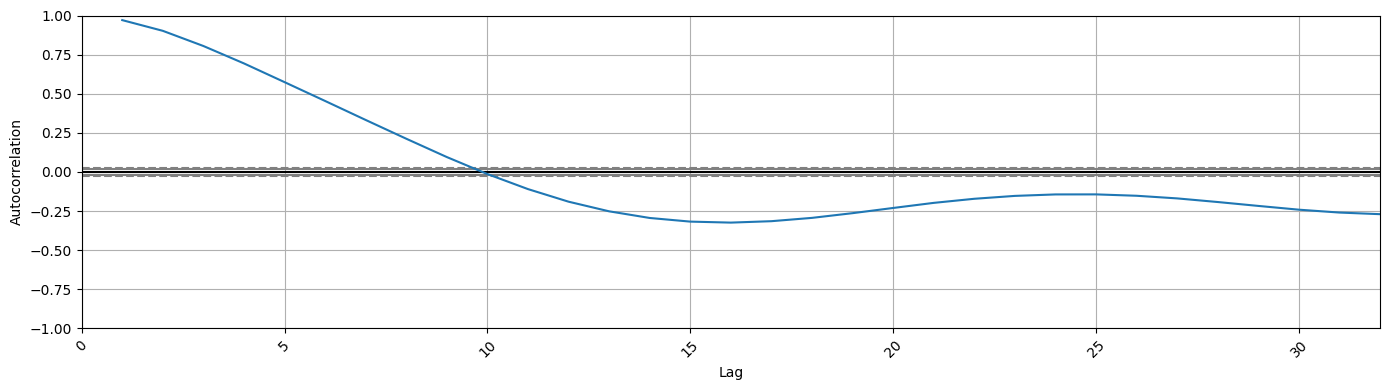

In [4]:
util.plot_autocorrelation(data, max_lag=32, figsize=figsize)

* The correlation is strong up to 4-5 lags

## Temporal Correlations

**These correlations are _a source of information_**

* They could be exploited to improve our estimated probabilities
* ...But our models so far make _no use_ of them

> **How can we take advantage of them?**

**For example, rather then feeding our model with individual observations**

We can use _sequences of observations_ as input

* This is a _very common approach_ in time series
* ...And in many cases it's a good idea

## Sliding Window

**A common approach consist in using a _sliding window_**

<center><img src="assets/sliding_window.svg" width="800px"/></center>

* We choose a _window length $w$_, i.e. the length of each sub-sequence
* We place the "window" at the beginning of the series
* ...We extract the corresponding observations
* Then, we move the forward by a certain _stride_ and we repeat

## Sliding Window

**The result is a table**

Let $m$ be the number of examples and $w$ be the window length

|               | $\bf s_0$ | $\bf s_1$    | $\bf \ldots$ | $\bf s_{w-1}$ |
| ------------- | --------- | ------------ | ------------ | ------------- | 
| $\bf t_{w-1}$ | $x_0$     | $x_1$        | $\ldots$     | $x_{w-1}$     |
| $\bf t_{w}$   | $x_1$     | $x_2$        | $\ldots$     | $x_{w}$       |
| $\bf t_{w+1}$ | $x_2$     | $x_3$        | $\ldots$     | $x_{w+1}$     |
| $\bf \vdots$  | $\vdots$  | $\vdots$     | $\vdots$     | $\vdots$      |
| $\bf t_{m-1}$ | $x_{m-w}$ | $x_{m-w+1}$  | $\vdots$     | $x_{m-1}$     |

* The first window includes observations from $x_0$ to $x_{w-1}$
* The second from $x_1$ to $x_{w}$ and so on
* $t_i$ is the _time window index_ (where it was applied)
* $s_j$ is the _position_ of an observation _within a window_


## Sliding Window in pandas

**pandas provides a sliding window _iterator_**

```python
DataFrame.rolling(window, ...)
```

In [5]:
wlen = 10
for i, w in enumerate(data['value'].rolling(wlen)):
    print(w)
    if i == 2: break # We print the first three windows

timestamp
2014-07-01    10844
Name: value, dtype: int64
timestamp
2014-07-01 00:00:00    10844
2014-07-01 00:30:00     8127
Name: value, dtype: int64
timestamp
2014-07-01 00:00:00    10844
2014-07-01 00:30:00     8127
2014-07-01 01:00:00     6210
Name: value, dtype: int64


Notice how the first windows are not full (shorter than `wlen`)

## Sliding Window in pandas

**We can build our dataset using the `rolling` iterator**

* We discard the first `wlen-1` (incomplete) applications
* Then we store each window in a list, and we wrap everything in a `DataFrame`

In [6]:
%%time
rows = []
for i, w in enumerate(data['value'].rolling(wlen)):
    if i >= wlen-1: rows.append(w.values)

wdata_index = data.index[wlen-1:]
wdata = pd.DataFrame(index=wdata_index, columns=range(wlen), data=rows)

CPU times: user 449 ms, sys: 5.99 ms, total: 455 ms
Wall time: 455 ms


* The `values` field allows access to the `Series` content as a numpy array
* We use it to _discard the index_
* ...Since the series for multiple iterations have inconsistent indexes

## Sliding Window in pandas

**This method works, but _it's a bit slow_**

* We are building our table by rows...
* ...But it is usually _faster to do it by columns_!
* After all, there are usually _fewer columns than rows_

**Let us look again at our table:**

|               | $\bf s_0$ | $\bf s_1$    | $\bf \ldots$ | $\bf s_{w-1}$ |
| ------------- | --------- | ------------ | ------------ | ------------- | 
| $\bf t_{w-1}$ | $x_0$     | $x_1$        | $\ldots$     | $x_{w-1}$     |
| $\bf t_{w}$   | $x_1$     | $x_2$        | $\ldots$     | $x_{w}$       |
| $\bf t_{w+1}$ | $x_2$     | $x_3$        | $\ldots$     | $x_{w+1}$     |
| $\bf \vdots$  | $\vdots$  | $\vdots$     | $\vdots$     | $\vdots$      |
| $\bf t_{m-1}$ | $x_{m-w}$ | $x_{m-w+1}$  | $\vdots$     | $x_{m-1}$     |

## Sliding Window in pandas

**We can build the columns by _slicing the original `DataFrame`_**

In [7]:
m = len(data)
c0 = data.iloc[0:m-wlen+1]   # first column
c1 = data.iloc[1:m-wlen+1+1] # second column
print(c0.iloc[0:3])
print(c1.iloc[0:3])

                     value
timestamp                 
2014-07-01 00:00:00  10844
2014-07-01 00:30:00   8127
2014-07-01 01:00:00   6210
                     value
timestamp                 
2014-07-01 00:30:00   8127
2014-07-01 01:00:00   6210
2014-07-01 01:30:00   4656


* `iloc` in pandas allows to address a `DataFrame` by _position_

## Sliding Window in pandas

**Now we collect all columns in a list and we _stack them_**

In [8]:
lc = [data.iloc[i:m-wlen+i+1].values for i in range(0, wlen)]
lc = np.hstack(lc)
wdata = pd.DataFrame(index=wdata_index, columns=range(wlen), data=lc)
wdata.head()

,0,1,2,3,4,5,6,7,8,9
timestamp,,,,,,,,,,
2014-07-01 04:30:00,10844,8127,6210,4656,3820,2873,2369,2064,2221,2158
2014-07-01 05:00:00,8127,6210,4656,3820,2873,2369,2064,2221,2158,2515
2014-07-01 05:30:00,6210,4656,3820,2873,2369,2064,2221,2158,2515,4364
2014-07-01 06:00:00,4656,3820,2873,2369,2064,2221,2158,2515,4364,6526
2014-07-01 06:30:00,3820,2873,2369,2064,2221,2158,2515,4364,6526,11039


## Sliding Window in pandas

**We can wrap this approach in a function:**

```python
def sliding_window_1D(data, wlen):
    m = len(data)
    lc = [data.iloc[i:m-wlen+i+1] for i in range(0, wlen)]
    wdata = np.hstack(lc)
    wdata = pd.DataFrame(index=data.index[wlen-1:], data=wdata, columns=range(wlen))
    return wdata
```

In [9]:
%%time
wdata = util.sliding_window_1D(data, wlen=wlen)

CPU times: user 1.42 ms, sys: 0 ns, total: 1.42 ms
Wall time: 1.13 ms


* This is available in the (updated)) `nab` module
* The function works for _univariate_ data (but the approach is general)